In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
from numba import jit
from scipy.optimize import brentq

In [2]:
#parameters

mu = 0.34
eta = 0.01
beta = 0.99 #change to 0.99 for final
theta = 0.36
delta = 0.025
rho = 0.9
sigma = 2
nz = 3
nk = 5
tol=1e-10,
maxit=10000

In [13]:
#this is the hw2_ex_v3 code from Rajesh--edit to fit our needs

class Ramsey_Econ602:

    def __init__(self,
                 mu,
                 sigma,
                 beta,
                 theta,
                 delta,
                 rho,
                 eta,
                 nk=100,
                 nz=5,
                 tol=1e-10,
                 maxit=10000):
        
        self.mu = mu
        self.sigma = sigma
        self.beta = beta
        self.theta = theta
        self.delta = delta
        self.rho = rho
        self.eta = eta
        self.nk = nk
        self.nz = nz
        
        # get the state values and transition matrix from the markov chain for z
        self.markov_chain = qe.markov.tauchen(rho, eta, 0, 3, nz)
        self.z_state_values = self.markov_chain.state_values #the formula we're given is ln(z) = rho*ln(z_{-1}) + epsilon_i
        self.transition_matrix = self.markov_chain.P
                                
        #steady state k and l (capital and leisure)
        #these are just to approximate bounds for a linear space that we'll iterate over
        self.ls = (1-theta)/(((1-mu)/mu)+1-theta-((1-mu)/mu)*((delta*theta)/(1/beta-(1-delta))))
        self.ks = self.ls*((1/beta-(1-delta))/theta)**(1/(theta-1))
        
        #need self.kgrid and zgrid because k and z are our state variables
        self.kgrid = np.linspace(0.5*self.ks, 2*self.ks, nk)
        self.zgrid = np.exp(self.z_state_values)

        # Allocate memory--essentially we're just pre-defining the shape of objects we'll pass into functions to fill later
        self.v = np.zeros((nz,nk)) #initial guess for Bellman is zeros
        self.gk_index = np.empty((nz,nk))
        self.gpr = np.empty((nz,nk))
        self.Ret = np.zeros((nz,nk,nk))
        l = np.empty((nz,nk,nk))
        
        #here's where we need to solve for leisure
        
        for z_i in range(nz):
            for k_i in range(nk):
                for k_prime_i in range(nk):
                    kz = (self.kgrid[k_prime_i]-(1-delta)*self.kgrid[k_i])/(self.zgrid[z_i]*(self.kgrid[k_i])**theta)
                    if kz >= 1:
                        l[z_i,k_i,k_prime_i] = 1
                    else:
                        l[z_i,k_i,k_prime_i] = brentq(lambda x: (x**(1-theta))*((1-mu)/mu + 1-theta - (1-theta)/x) - ((1-mu)/mu)*kz,0.0000000001,1)
    
        self.l = l
        
        # compute the return function
        _compute_returns(self.kgrid,self.zgrid,self.delta,self.theta,self.mu,self.sigma,self.l,self.Ret)
                
        # Compute the value function and policy function
        self.solve(tol=tol, maxit=maxit)
        self.kpr_policy()
        self.endog_dist()
   
    # solve is the actual value function iteration
    def solve(self, tol=1e-9, maxit=10000):
        # Iteration Stuff
        it = 0
        dist = 10.

        # Allocate memory to store next iterate of value function
        v_upd = np.zeros((self.nz,self.nk))
        
        # Main loop
        while dist > tol and maxit > it:
            
            self.E_v = np.matmul(self.transition_matrix, self.v)
            
            _inner_loop(self.Ret,self.v,self.E_v,self.beta,self.zgrid,self.kgrid)
            
            dist = np.max(np.abs(v_upd - self.v))
            v_upd[:] = self.v[:]

            it += 1
            if it % 25 == 0:
                print(f"Running iteration {it} with dist of {dist}")

        return None    
        
    # This is to recover policy function after the value function has converged
    
    def kpr_policy(self):
    
    # Compute gpr and its index: best index in kgrid given ik  
        self.gpr = np.empty((self.nz,self.nk))
        self.kgpr = np.empty((self.nz,self.nk))

        _compute_savings_policy(self.kgrid, self.zgrid, self.Ret, self.v, self.E_v, self.beta, self.gpr,self.kgpr)
        
    def endog_dist(self):
        self.g = np.zeros((self.nz*self.nk,self.nz*self.nk))
        self.prob = (1/(self.nz*self.nk))*np.ones((self.nz*self.nk))
        self.dist = np.zeros((self.nk))
        
        _state_t1(self.transition_matrix,self.gpr,self.g)
        
        test = 1
        while test > 10**(-10):
            prob1 = self.prob @ self.g
            test = np.max(np.abs(prob1-self.prob))
            self.prob = prob1
        
        _state_t2(self.nz,self.nk,self.prob,self.dist)
        
        return (self.g,self.prob,self.dist)

# Just to compute utility--need to solve for leisure before this can work        
@jit(nopython=True)
def u(c, l, mu, sigma):
    return (1/(1-sigma))*((c**mu)*((1-l)**(1-mu)))**(1-sigma)

#we need to get the expected value of the bellman by multiplying v(z',k') with the corresponding value in the transition matrix
@jit(nopython=True)
def _inner_loop(Ret,v,E_v,beta,zgrid,kgrid):
    for z_i in range(len(zgrid)):
        for k_i in range(len(kgrid)):
            current_max = -1e14
            for k_prime_i in range(len(kgrid)):
                # m is the Bellman: Ret is utility, and E_v is expected bellman
                m = Ret[z_i,k_i,k_prime_i] + beta * E_v[z_i,k_prime_i]

                if m > current_max:
                    current_max = m      

                v[z_i,k_i] = current_max  
            
    return None

#this will have an nz loop added too
#need the expected value of the Bellman here too
@jit(nopython=True)
def _compute_savings_policy(kgrid,zgrid,Ret,v,E_v,beta,gpr,kgpr):
    for z_i in range(len(zgrid)):
        for k_i in range(len(kgrid)):
            current_max = -1e14
            for k_prime_i in range(len(kgrid)):
                m = Ret[z_i,k_i,k_prime_i] + beta * E_v[z_i,k_prime_i]
                if m > current_max:
                    current_max = m
                    current_max_index = k_prime_i
            gpr[z_i,k_i] = kgrid[current_max_index]
            kgpr[z_i,k_i] = current_max_index
    return None 

#this will have an nz loop added too
@jit(nopython=True)
def _compute_returns(kgrid,zgrid,delta,theta,mu,sigma,l,Ret):
    for z_i in range(len(zgrid)):
        for k_i in range(len(kgrid)):
            for k_prime_i in range(len(kgrid)):
                #l_i is just the number corresponding to the z_i, k_i, k_prime_i position in the l matrix
                l_i = l[z_i,k_i,k_prime_i]
                if l_i == 1:
                    Ret[z_i,k_i,k_prime_i] = -1e+14
                else:
                    c = zgrid[z_i]*(kgrid[k_i]**theta)*(l_i**(1-theta))-kgrid[k_prime_i]+(1-delta)*kgrid[k_i]
                    if c <= 0:
                        Ret[z_i,k_i,k_prime_i] = -1e+14
                    else: 
                        Ret[z_i,k_i,k_prime_i] = u(c, l_i, mu, sigma)
    return None

#this doesn't work because the indices for g are negative and decimal
#@jit(nopython=True)
def _state_t1(Py, kgpr, g):
    
    nz,nk = kgpr.shape
    
    for iz in range(nz):
        for ik in range(nk):
            for izpr in range(nz):
                print(f"iz: {iz}")
                print(f"ik: {ik}")
                print(f"izpr: {izpr}")
                print(f"kgpr[iz,ik]: {kgpr[iz,ik]}")
                print(f"g indices: {(iz-1)*nk + ik, (izpr-1)*nk + kgpr[iz,ik]}")
                g[iz * nk + ik, izpr * nk + kgpr[iz,ik]] = Py[iz,izpr]
                
    return None
                
#@jit(nopython=True)
def _state_t2(nz,nk,prob,dist):
    
    for iz in range(nz):
        for ik in range(nk):
            dist[ik] = dist[ik] + prob[(iz-1)*nk + ik]

    return None

In [14]:
ramsey = Ramsey_Econ602(mu,
                sigma,
                beta,
                theta,
                delta,
                rho,
                eta,
                nk,
                nz,
                tol=1e-10,
                maxit=10000)

Running iteration 25 with dist of 1.137044757794353
Running iteration 50 with dist of 0.882767195865064
Running iteration 75 with dist of 0.6854432086968245
Running iteration 100 with dist of 0.5322915387926912
Running iteration 125 with dist of 0.41340604358650523
Running iteration 150 with dist of 0.32110707296901353
Running iteration 175 with dist of 0.24943968902334746
Running iteration 200 with dist of 0.19378534362844846
Running iteration 225 with dist of 0.15056125781310925
Running iteration 250 with dist of 0.11698762152579434
Running iteration 275 with dist of 0.09090725969099367
Running iteration 300 with dist of 0.07064590121524361
Running iteration 325 with dist of 0.05490388074699126
Running iteration 350 with dist of 0.042672181840544
Running iteration 375 with dist of 0.033167335633123685
Running iteration 400 with dist of 0.025780929594702684
Running iteration 425 with dist of 0.02004043975659897
Running iteration 450 with dist of 0.015578841299799251
Running iteration 

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [5]:
ramsey.kgpr

array([[0., 1., 2., 2., 3.],
       [0., 1., 2., 3., 3.],
       [0., 1., 2., 3., 3.]])

In [7]:
G = np.zeros((ramsey.transition_matrix.shape[0]*nk,
              ramsey.transition_matrix.shape[0]*nk))
g_cols = []
g_rows = []

for z_i in range(nz):
    for k_i in range(nk):
        g_cols.append((z_i,k_i))
        g_rows.append((z_i,k_i))
        #for z_prime_i in range(nz):


G = pd.DataFrame(G, columns = g_cols, index = g_rows)
prob = pd.DataFrame(ramsey.transition_matrix)


for col in G.columns:
    for row in G.index:
        if col[1] == int(ramsey.kgpr[row]):
            G.at[row,col] = prob.at[row[0],col[0]]
            
G.round(decimals = 4)

0                                    1                          \
             0       1       2       3    4       0       1       2       3   
(0, 0)  0.9970  0.0000  0.0000  0.0000  0.0  0.0030  0.0000  0.0000  0.0000   
(0, 1)  0.0000  0.9970  0.0000  0.0000  0.0  0.0000  0.0030  0.0000  0.0000   
(0, 2)  0.0000  0.0000  0.9970  0.0000  0.0  0.0000  0.0000  0.0030  0.0000   
(0, 3)  0.0000  0.0000  0.9970  0.0000  0.0  0.0000  0.0000  0.0030  0.0000   
(0, 4)  0.0000  0.0000  0.0000  0.9970  0.0  0.0000  0.0000  0.0000  0.0030   
(1, 0)  0.0003  0.0000  0.0000  0.0000  0.0  0.9994  0.0000  0.0000  0.0000   
(1, 1)  0.0000  0.0003  0.0000  0.0000  0.0  0.0000  0.9994  0.0000  0.0000   
(1, 2)  0.0000  0.0000  0.0003  0.0000  0.0  0.0000  0.0000  0.9994  0.0000   
(1, 3)  0.0000  0.0000  0.0000  0.0003  0.0  0.0000  0.0000  0.0000  0.9994   
(1, 4)  0.0000  0.0000  0.0000  0.0003  0.0  0.0000  0.0000  0.0000  0.9994   
(2, 0)  0.0000  0.0000  0.0000  0.0000  0.0  0.0030  0.0000  0.0000  0.0000   
(2, 1)  0.0000  0.0000  0.0000  0.0000  0.0  0.0000  0.0030  0.0000  0.0000   
(2, 2)  0.0000  0.0000  0.0000  0.0000  0.0  0.0000  0.0000  0.0030  0.0000   
(2, 3)  0.0000  0.0000  0.0000  0.0000  0.0  0.0000  0.0000  0.0000  0.0030   
(2, 4)  0.0000  0.0000  0.0000  0.0000  0.0  0.0000  0.0000  0.0000  0.0030   

                  2                               
          4       0       1       2       3    4  
(0, 0)  0.0  0.0000  0.0000  0.0000  0.0000  0.0  
(0, 1)  0.0  0.0000  0.0000  0.0000  0.0000  0.0  
(0, 2)  0.0  0.0000  0.0000  0.0000  0.0000  0.0  
(0, 3)  0.0  0.0000  0.0000  0.0000  0.0000  0.0  
(0, 4)  0.0  0.0000  0.0000  0.0000  0.0000  0.0  
(1, 0)  0.0  0.0003  0.0000  0.0000  0.0000  0.0  
(1, 1)  0.0  0.0000  0.0003  0.0000  0.0000  0.0  
(1, 2)  0.0  0.0000  0.0000  0.0003  0.0000  0.0  
(1, 3)  0.0  0.0000  0.0000  0.0000  0.0003  0.0  
(1, 4)  0.0  0.0000  0.0000  0.0000  0.0003  0.0  
(2, 0)  0.0  0.9970  0.0000  0.0000  0.0000  0.0  
(2, 1)  0.0  0.0000  0.9970  0.0000  0.0000  0.0  
(2, 2)  0.0  0.0000  0.0000  0.9970  0.0000  0.0  
(2, 3)  0.0  0.0000  0.0000  0.0000  0.9970  0.0  
(2, 4)  0.0  0.0000  0.0000  0.0000  0.9970  0.0

In [19]:
ramsey.kgpr

array([[0., 1., 2., 2., 3.],
       [0., 1., 2., 3., 3.],
       [0., 1., 2., 3., 3.]])

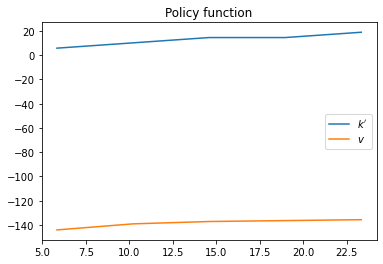

In [8]:
#need these to be 3d
fig, ax = plt.subplots()
ax.set_title("Policy function")

    
ax.plot(ramsey.kgrid, ramsey.gpr[0], label="$k'$")
ax.legend()

ax.plot(ramsey.kgrid, ramsey.v[0], label="$v$")
ax.legend()
plt.show()

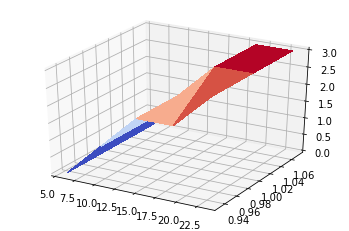

In [9]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
xx, yy = ramsey.kgrid, ramsey.zgrid 
X, Y = np.meshgrid(xx, yy)
Z = ramsey.kgpr #v is value and gpr is saving policy

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.show()

In [24]:
nk

10

In [12]:
#print(pd.DataFrame(ramsey.g))
#print(pd.DataFrame(ramsey.prob))
print(pd.DataFrame(ramsey.dist))

plt.plot(ramsey.dist)

AttributeError: 'Ramsey_Econ602' object has no attribute 'dist'